### Code for Section 4 - Applications of Static Models (SES)  
##### Author: Evan Munro (munro@stanford.edu) 

This notebook contains the code for estimating figures and tables from Section 4 of the paper. 

For now, while I am iterating through different applications, I use existing packages for GoM, LDA and latent class. Eventually, I plan on adding a sampler for each of those models to dhlvm. 

Each of these models are estimated on the cleaned DHS data that I received from Marshall Burke. 

#### I. Prepare Data

The country codes are based on the ISO alpha-2 standard. For this example,I have chosen to work with all the survey data from sub-saharan Africa in 2014. First, load packages and raw data. 

In [2]:
setwd("~/Documents/Data/DHS_Burke/")
library(topicmodels)
library(mixedMem)
library(readstata13)
library(dplyr)
library(tidyr)
library(ggplot2) 
rawData = read.dta13("dhs_41417_indexed_weighted.dta")
head(rawData)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



hhid,rooms,hv000,hv001,year,cname,water_qual,toilet_qual,floor_qual,electric,radio,tv,fridge,motorbike,car,phone,hhwt,weight,index
276 60,2,AF7,276,1394,AF,1,3,3,1,1,1,0,1,0,1,0.361154,99,0.20820500
235 72,1,AF7,235,1394,AF,4,3,3,1,0,0,0,0,0,1,0.964907,99,-0.09710647
954 15,1,AF7,954,1394,AF,4,3,4,0,1,0,0,0,0,1,0.408666,99,-0.24276462
544 53,1,AF7,544,1394,AF,4,3,4,1,0,1,0,0,0,1,0.585597,99,0.47130045
581 47,2,AF7,581,1394,AF,1,3,4,1,0,0,0,0,0,1,1.918440,99,-0.26586077
845189,2,AF7,845,1394,AF,4,3,4,0,0,0,0,0,0,1,1.361916,99,-0.40023568


Then, select data from Latin Amerixa after 2009 only. 

In [3]:
print(unique(rawData$cname))
asia_code = c("AZ","AF","BD","ID","JO","KH","LB",
              "MM","NP","PH","PK","TJ","UZ","YE")
latin_code = c("BO","CO","DR","GY","HT","NI","PE","VN")
north_af_code = c("EG","ET","ML","TD")
europe_code = c("MD","UA")
subsaharan_code =c("AL","BF","BJ","CD","CF","CG","CI","CM","GA","GH","GM",
             "GN","KE","LS","MW","MZ","NG","RW","SL","SN","ST",
             "SZ","TG","TZ","UG","ZA","ZM","ZW")
subsaharan_name = c("Angola","Burkina Faso","Benin","DRC","Central African Republic",
          "Congo","Cote DIvoire","Cameroon","Gabon","Ghana","Gambia","Guinea",
          "Kenya","Lesotho","Malawi","Mozambique","Nigeria","Rwanda","Sierra Leone",
          "Senegal","Sao Tome and Principe","Swaziland","Togo","Tanzania","Uganda",
            "South Africa","Zambia","Zimbabwe")

index.vars = colnames(rawData)[7:16]

subsaharan <- rawData %>%
                filter(year >=2009) %>%
               filter(cname %in% latin_code) %>% 
                select(append(c("year","cname","index","hhwt"),index.vars))

table(subsaharan$cname)
subsaharan[subsaharan$water_qual %in% c(3,4,5),"water_qual"] = subsaharan[subsaharan$water_qual %in% c(3,4,5),"water_qual"] -1 
subsaharan[subsaharan$floor_qual %in% c(3,4,5),"floor_qual"] = subsaharan[subsaharan$floor_qual %in% c(3,4,5),"floor_qual"] -1 
head(subsaharan)

print(dim(subsaharan))
print(unique(subsaharan$year))

#colSums(table(rawData$cname,rawData$year)!=0)

 [1] "AF" "AL" "AM" "AO" "AZ" "BD" "BF" "BJ" "BO" "BU" "CD" "CF" "CG" "CI" "CM"
[16] "CO" "DR" "EG" "ET" "GA" "GH" "GM" "GN" "GU" "GY" "HT" "IA" "ID" "JO" "KE"
[31] "KH" "KK" "KM" "KY" "LB" "LS" "MB" "MD" "ML" "MM" "MV" "MW" "MZ" "NC" "NG"
[46] "NI" "NM" "NP" "PE" "PH" "PK" "RW" "SL" "SN" "ST" "SZ" "TD" "TG" "TJ" "TL"
[61] "TZ" "UA" "UG" "UZ" "VN" "YE" "ZA" "ZM" "ZW"



    CO     GY     HT     NI     PE 
 51447   5445  12839  10702 107183 

year,cname,index,hhwt,water_qual,toilet_qual,floor_qual,electric,radio,tv,fridge,motorbike,car,phone
2010,CO,1.433201,0.843376,4,5,3,1,1,1,1,1,0,1
2009,CO,1.433201,0.554607,4,5,3,1,1,1,1,0,0,1
2010,CO,1.433201,0.763760,4,5,3,1,1,1,1,0,0,1
2010,CO,1.433201,2.601527,4,5,3,1,1,1,1,0,0,1
2010,CO,1.433201,0.298317,4,5,3,1,1,1,1,0,0,1
2010,CO,1.433201,0.053970,4,5,3,1,1,1,1,0,0,1


[1] 187616     14
[1] 2010 2009 2012 2011


#### II. Estimate Baseline Principal Components Based Models

In [5]:
polyt <- c("water_qual","toilet_qual","floor_qual")
subsaharan.fprit<- subsaharan
subsaharan.fprit[,polyt] <- apply(subsaharan.fprit[,polyt],MARGIN=2,FUN=as.factor)
subsaharan.fprit <- model.matrix(~.-1,data=subsaharan.fprit[index.vars])

In [6]:
library(psych) 
pca <- prcomp(subsaharan[,index.vars], center = TRUE,scale. = TRUE)
fprit <- prcomp(subsaharan.fprit,center=TRUE,scale.=TRUE)
pchlor <- fa(subsaharan[,index.vars],rotation=None, cor="poly") 

subsaharan$pca = -pca$x[,1]
subsaharan$fprit = -fprit$x[,1]
subsaharan$pchlor= pchlor$scores[,1]



Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

Warning message in matpLower(x, nvar, gminx, gmaxx, gminy, gmaxy):
“45 cells were adjusted for 0 values using the correction for continuity. Examine your data carefully.”

#### II. Country-Specific Index (LDA)

In [393]:
#Prepare data for LDA (using household weights) 
subsaharan$all = apply(subsaharan[,index.vars],MARGIN=1,paste,collapse="")
weighted = F
if (weighted) { 
    subsaharan.counts =  subsaharan %>%
                    group_by(cname,all) %>%
                    summarize(hhwt=floor(sum(hhwt))) %>%
                    spread(all,hhwt,fill=0) 
                

    subsaharan.counts = as.data.frame(subsaharan.counts)
    subsaharan.counts = select(subsaharan.counts,-cname)
    rownames(subsaharan.counts) = baseline$cname
} else { 
    subsaharan.counts = t(table(subsaharan$all,subsaharan$cname))
}
dim(subsaharan.counts)
    

[1]    5 2867

In [499]:
#estimate the model 

lda.model = LDA(subsaharan.counts,method="Gibbs",k=2,control=list(seed=2017,burnin=100))
theta.lda = posterior(lda.model)$topics
beta.lda = posterior(lda.model)$terms
#indexes[,c("pca","fprit","pchlor")] <- apply(indexes[,c("pca","fprit","pchlor")],MARGIN=2,FUN=function(x) return((x-min(x))/(max(x)-min(x))))
theta.lda

indexes <- subsaharan %>%
            group_by(cname) %>%
            summarize(pca=mean(pca),fprit=mean(fprit),
                      pchlor=mean(pchlor))
indexes


,1,2
CO,0.001922442,0.998077558
GY,0.448225660,0.551774340
HT,0.988206998,0.011793002
NI,0.992838542,0.007161458
PE,0.726502103,0.273497897


cname,pca,fprit,pchlor
CO,1.10099496,1.20229367,0.61640488
GY,0.12729222,-0.28191920,0.04917278
HT,-1.87442037,-2.42138994,-1.15710544
NI,-2.32821558,-2.47539035,-1.29526958
PE,-0.07793911,-0.02555908,-0.03043277


In [509]:

sort(beta.lda[1,],decreasing=TRUE)[1:10]
sort(beta.lda[2,],decreasing=TRUE)[1:10] 



#ggplot(indexes, aes(pca, lda)) + 
 # geom_point()+theme_bw()+labs(title="Full Sample Estimate")
#ggsave("subsaharan14_dhs.png",width=5,height=5)

#cor.test(indexes$lda,indexes$pca)
#cor.test(indexes$lda,indexes$fprit)
#corr.test(indexes$lda,indexes$pchlor)


4531110001 4541111001 4211110001 4511110001 4541111011 1110000000 3110000000 
0.06303399 0.03847629 0.02763438 0.02446254 0.02068517 0.01878207 0.01717693 
1110100000 4231110001 1210100000 
0.01628305 0.01413966 0.01288054

4531111001  4531111101  4531111011  4531110001  4531011001  4531010001 
0.302073591 0.093858847 0.057981882 0.053596788 0.051849880 0.032194199 
 4531111111  4531011101  1531111001  4531000001 
0.020488730 0.016769124 0.010755959 0.009971634

#### III. Individual-Specific Index (GoM) 

Next, I estimate the GoM model and look at country-level aggregated data as well as individual scores. First, prepare GoM data and input parameters. 

In [7]:
K=4

subsaharan.gom = subsaharan[,index.vars]
subsaharan.gom[,polyt] = subsaharan.gom[,polyt] -1 
Total = nrow(subsaharan.gom)
J  = ncol(subsaharan.gom)
# only one replicate for each of vars 
Rj = rep(1,J)
#Nijr is number of ranking levels 
#All data i s multinomial so it should be array of all 1s 
Nijr = array(1,dim=c(Total,J,max(Rj)))

#apply nunique to each column 
Vj = apply(subsaharan.gom,MARGIN=2,function(x) return(length(unique(x))))
Vj[Vj==2] =1 
alpha = rep(1,K)

dist = rep("multinomial",length(Vj))
dist[Vj==1] = "bernoulli"

obs = array(0,dim=c(Total,J,max(Rj),max(Nijr)))
obs[, , 1, 1] = as.matrix(sapply(subsaharan.gom,as.numeric))

theta <- array(0, dim=c(J,K,max(Vj)))

for (j in 1:J) {
  if(Vj[j]==1)
    theta[j,,1] = rep(runif(1),K) 
  else 
    theta[j, ,1:Vj[j]] = gtools::rdirichlet(K,rep(1,Vj[j]))
}

initial = mixedMemModel(Total=Total,J=J,Rj=Rj,
                        Nijr=Nijr,K=K,Vj=Vj,alpha=alpha,
                        theta=theta,dist=dist,obs=obs)

computeELBO(initial)

[1] -7133259

In [8]:
out = mmVarFit(initial,printMod=25)
computeELBO(out)
computeBIC(out)
phis = as.data.frame(out$phi)

[1] "Model Check: Ok!"
[1] "<== Beginning Model Fit! ==>"
Iter: 25 Elbo: -1.24596e+06
E-Step: -1.24572e+06
M-Step: -1.24549e+06
Iter: 50 Elbo: -1.24017e+06
E-Step: -1.24011e+06
M-Step: -1.24006e+06
Iter: 75 Elbo: -1.23842e+06
E-Step: -1.23839e+06
M-Step: -1.23837e+06
Iter: 100 Elbo: -1.23759e+06
E-Step: -1.23758e+06
M-Step: -1.23757e+06
Iter: 125 Elbo: -1.23712e+06
E-Step: -1.23711e+06
M-Step: -1.2371e+06
Iter: 150 Elbo: -1.23681e+06
E-Step: -1.23681e+06
M-Step: -1.2368e+06
Iter: 175 Elbo: -1.2366e+06
E-Step: -1.23659e+06
M-Step: -1.23659e+06
Iter: 200 Elbo: -1.23644e+06
E-Step: -1.23644e+06
M-Step: -1.23643e+06
Iter: 225 Elbo: -1.23632e+06
E-Step: -1.23631e+06
M-Step: -1.23631e+06
Iter: 250 Elbo: -1.23622e+06
E-Step: -1.23622e+06
M-Step: -1.23622e+06
Iter: 275 Elbo: -1.23614e+06
E-Step: -1.23614e+06
M-Step: -1.23614e+06
Iter: 300 Elbo: -1.23608e+06
E-Step: -1.23608e+06
M-Step: -1.23607e+06
Iter: 325 Elbo: -1.23602e+06
E-Step: -1.23602e+06
M-Step: -1.23602e+06
Iter: 350 Elbo: -1.23597e

[1] -1235874

Var 1 
2472282

            [,1]
Group 1 1.350812
Group 2 3.996533
Group 3 2.933703
Group 4 3.998240
            [,1]
Group 1 2.121549
Group 2 4.188906
Group 3 1.651573
Group 4 4.996934
            [,1]
Group 1 1.005199
Group 2 2.518129
Group 3 2.258056
Group 4 2.998912
              [,1]
Group 1 0.08276685
Group 2 0.99982202
Group 3 0.64576988
Group 4 0.99999509
             [,1]
Group 1 0.2308222
Group 2 0.9869118
Group 3 0.4011124
Group 4 0.9949855
             [,1]
Group 1 0.0212381
Group 2 0.9982067
Group 3 0.2832699
Group 4 0.9999589
                [,1]
Group 1 0.0002576508
Group 2 0.2948371730
Group 3 0.0030243950
Group 4 0.9708611581
               [,1]
Group 1 0.002485527
Group 2 0.039329501
Group 3 0.005732581
Group 4 0.432286898
                [,1]
Group 1 6.218439e-05
Group 2 1.224502e-02
Group 3 3.391369e-04
Group 4 2.561247e-01
              [,1]
Group 1 0.04476268
Group 2 0.99660159
Group 3 0.60705899
Group 4 0.99989547


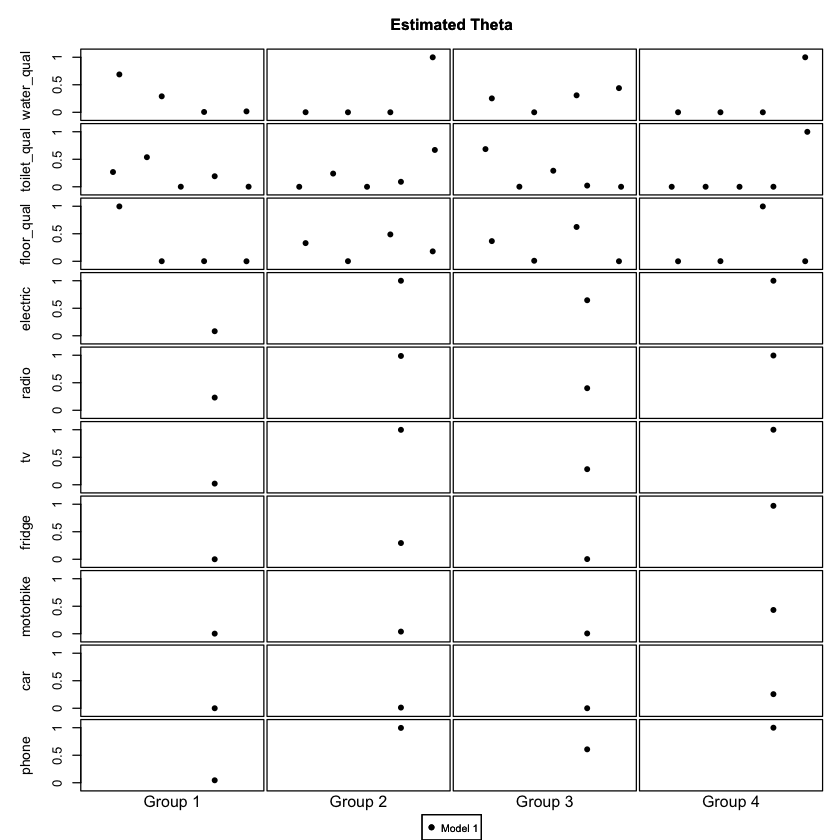

In [9]:
model.gom <- out
theta.gom = t(t(phis)/colSums(t(phis)))
#head(theta.gom)

beta.gom <- out$theta

subsaharan$gom <- theta.gom[,2]

plot(out,type="theta",varNames=index.vars)
#head(subsaharan)
#cor.test(subsaharan$gom,subsaharan$pca)


for (j in 1:length(index.vars)) {
    print(as.matrix(beta.gom[j,,])%*%matrix (1:5, nrow = 5, ncol = 1))
}



In [12]:
setwd("~/Documents/Github/multinomial-ts-paper")
source("utils.R")
setwd("~/Dropbox/evan/notes/figures/")
pdf("gomk4.pdf", width = 5, height = 7)
vizTheta(out,varNames=index.vars,main="Estimated Beta",groupNames=c("Profile 1","Profile 2","Profile 3","Profile 4"))
dev.off()

pdf 
  2

#### IV. Multinomial Mixture Model

For the Multinomial Mixture Model, I also use data for Kenya only. 

In [400]:
library(DirichletMultinomial) 

model.mmm <- dmn(as.matrix(subsaharan.counts), 2, verbose = FALSE, seed = 100)

str(model.mmm)


Formal class 'DMN' [package "DirichletMultinomial"] with 4 slots
  ..@ goodnessOfFit: Named num [1:5] 38086 -1717 31957 42701 43821
  .. ..- attr(*, "names")= chr [1:5] "NLE" "LogDet" "Laplace" "BIC" ...
  ..@ group        : num [1:5, 1:2] 0 1 1 1 1 1 0 0 0 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:5] "CO" "GY" "HT" "NI" ...
  .. .. ..$ : NULL
  ..@ mixture      :List of 1
  .. ..$ Weight: num [1:2] 0.8 0.2
  ..@ fit          :List of 3
  .. ..$ Lower   : num [1:2867, 1:2] 3.9043 0.6153 0.0122 0.0527 0.1279 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:2867] "1110000000" "1110000001" "1110000010" "1110000100" ...
  .. .. .. ..$ : NULL
  .. ..$ Estimate: num [1:2867, 1:2] 7.8423 1.6324 0.0804 0.2041 0.3815 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:2867] "1110000000" "1110000001" "1110000010" "1110000100" ...
  .. .. .. ..$ : NULL
  .. ..$ Upper   : num [1:2867, 1:2] 15.752 4.331 0.529 0.79 1.138 ...
  .. .. ..- attr

In [401]:
theta.mmm <- model.mmm@mixture

beta.mmm<-model.mmm@fit$Estimate

beta.mmm <- beta.mmm/colSums(beta.mmm)

beta.mmm <- t(beta.mmm)
print(xtable(cbind(sort(beta.mmm[1,],decreasing=TRUE)[1:10],sort(beta.mmm[2,],decreasing=TRUE)[1:10])))
sort(beta.mmm[2,],decreasing=TRUE)[1:10]

print(theta.mmm)

model.mmm@group

% latex table generated in R 3.5.1 by xtable 1.8-3 package
% Mon Feb 25 20:27:02 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 1 & 2 \\ 
  \hline
1110000000 & 0.01 & 2.19 \\ 
  4541111011 & 0.01 & 0.80 \\ 
  4541111001 & 0.01 & 0.43 \\ 
  4331111001 & 0.01 & 0.37 \\ 
  1210000000 & 0.01 & 0.18 \\ 
  3110000000 & 0.00 & 0.09 \\ 
  4231110001 & 0.00 & 0.08 \\ 
  4531010001 & 0.00 & 0.06 \\ 
  4110000000 & 0.00 & 0.06 \\ 
  1110100001 & 0.00 & 0.05 \\ 
   \hline
\end{tabular}
\end{table}


4531111001 4531111101 4531111011 4531110001 4531111111 1531111001 4531000001 
2.18757245 0.79941898 0.42612998 0.36918732 0.17817465 0.09486898 0.07829775 
4531011001 4431111001 1531111101 
0.05699505 0.05630250 0.05479631

$Weight
[1] 0.8 0.2



CO,0,1
GY,1,0
HT,1,0
NI,1,0
PE,1,0


#### V. Figures and Tables

Now that estimation and calculations are done, save figures and tables for use in the paper. First, the per-country results for each of the indexes. 

In [402]:
library(xtable)
summary.stat <- subsaharan[,append("cname",index.vars)] %>% 
                group_by(cname) %>%
                summarize_all(.funs=mean)  %>%
                mutate_at(index.vars,round,2)

summary.stat.scale <- apply(summary.stat[,index.vars],MARGIN=2,FUN=scale)

summary.stat
print(xtable(summary.stat))

cname,water_qual,toilet_qual,floor_qual,electric,radio,tv,fridge,motorbike,car,phone
CO,3.50,4.66,2.86,0.95,0.72,0.87,0.71,0.22,0.10,0.90
GY,2.78,3.95,2.92,0.71,0.55,0.73,0.55,0.09,0.14,0.80
HT,2.52,2.46,2.15,0.30,0.51,0.23,0.08,0.07,0.04,0.75
NI,3.24,1.75,1.52,0.23,0.53,0.19,0.06,0.15,0.04,0.56
PE,3.45,3.44,2.24,0.82,0.84,0.73,0.33,0.13,0.09,0.73


% latex table generated in R 3.5.1 by xtable 1.8-3 package
% Mon Feb 25 20:27:03 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlrrrrrrrrrr}
  \hline
 & cname & water\_qual & toilet\_qual & floor\_qual & electric & radio & tv & fridge & motorbike & car & phone \\ 
  \hline
1 & CO & 3.50 & 4.66 & 2.86 & 0.95 & 0.72 & 0.87 & 0.71 & 0.22 & 0.10 & 0.90 \\ 
  2 & GY & 2.78 & 3.95 & 2.92 & 0.71 & 0.55 & 0.73 & 0.55 & 0.09 & 0.14 & 0.80 \\ 
  3 & HT & 2.52 & 2.46 & 2.15 & 0.30 & 0.51 & 0.23 & 0.08 & 0.07 & 0.04 & 0.75 \\ 
  4 & NI & 3.24 & 1.75 & 1.52 & 0.23 & 0.53 & 0.19 & 0.06 & 0.15 & 0.04 & 0.56 \\ 
  5 & PE & 3.45 & 3.44 & 2.24 & 0.82 & 0.84 & 0.73 & 0.33 & 0.13 & 0.09 & 0.73 \\ 
   \hline
\end{tabular}
\end{table}


In [412]:

indexes <- subsaharan %>%
            group_by(cname) %>%
            summarize(pca=-mean(pca),fprit=mean(fprit),
                      pchlor=mean(pchlor),
                      gom=1-mean(gom)) 

indexes$lca <- 1-model.mmm@group[,1]
indexes$lda <- theta.lda[,2]
indexes$zscore <- rowMeans(summary.stat.scale)
index.names <- c("cname","pca","fprit","pchlor","zscore","gom","lda","lca")
indexes = indexes[,index.names]
indexes <-  indexes %>% 
            mutate_at(index.names[2:length(index.names)],round,2)
indexes
print(xtable(indexes))

cname,pca,fprit,pchlor,zscore,gom,lda,lca
CO,1.10,1.20,0.62,1.02,0.86,1.00,1
GY,0.13,-0.28,0.05,0.30,0.71,0.55,0
HT,-1.87,-2.42,-1.16,-0.81,0.35,0.01,0
NI,-2.33,-2.48,-1.30,-0.86,0.27,0.01,0
PE,-0.08,-0.03,-0.03,0.35,0.66,0.27,0


% latex table generated in R 3.5.1 by xtable 1.8-3 package
% Mon Feb 25 20:56:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlrrrrrrr}
  \hline
 & cname & pca & fprit & pchlor & zscore & gom & lda & lca \\ 
  \hline
1 & CO & 1.10 & 1.20 & 0.62 & 1.02 & 0.86 & 1.00 & 1.00 \\ 
  2 & GY & 0.13 & -0.28 & 0.05 & 0.30 & 0.71 & 0.55 & 0.00 \\ 
  3 & HT & -1.87 & -2.42 & -1.16 & -0.81 & 0.35 & 0.01 & 0.00 \\ 
  4 & NI & -2.33 & -2.48 & -1.30 & -0.86 & 0.27 & 0.01 & 0.00 \\ 
  5 & PE & -0.08 & -0.03 & -0.03 & 0.35 & 0.66 & 0.27 & 0.00 \\ 
   \hline
\end{tabular}
\end{table}


In [442]:
#hist(theta.gom)
library(gridExtra)
head(subsaharan)
p1<- qplot(subsaharan[subsaharan$cname=="NI","pca"])+theme_bw()+xlab("Nicaragua, PCA")
p2<-qplot(subsaharan[subsaharan$cname=="NI","gom"])+theme_bw() + xlab("Nicaragua, GoM")
p3<- qplot(subsaharan[subsaharan$cname=="GY","pca"])+theme_bw() + xlab("Guyana, PCA")
p4<-qplot(subsaharan[subsaharan$cname=="GY","gom"])+theme_bw() + xlab("Guyana, GoM")
pdf("histgom.pdf", width = 8, height = 5) # Open a new pdf file
grid.arrange(p1, p2,p3,p4, nrow = 2)
dev.off()


year,cname,index,hhwt,water_qual,toilet_qual,floor_qual,electric,radio,tv,fridge,motorbike,car,phone,gom,pca,fprit,pchlor
2010,CO,1.433201,0.843376,4,5,3,1,1,1,1,1,0,1,0.9768763,2.151458,2.317387,1.2578878
2009,CO,1.433201,0.554607,4,5,3,1,1,1,1,0,0,1,0.9766866,1.793520,2.017962,0.9278372
2010,CO,1.433201,0.763760,4,5,3,1,1,1,1,0,0,1,0.9766866,1.793520,2.017962,0.9278372
2010,CO,1.433201,2.601527,4,5,3,1,1,1,1,0,0,1,0.9766866,1.793520,2.017962,0.9278372
2010,CO,1.433201,0.298317,4,5,3,1,1,1,1,0,0,1,0.9766866,1.793520,2.017962,0.9278372
2010,CO,1.433201,0.053970,4,5,3,1,1,1,1,0,0,1,0.9766866,1.793520,2.017962,0.9278372


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


pdf 
  2

In [348]:
head(subsaharan)

year,cname,index,hhwt,water_qual,toilet_qual,floor_qual,electric,radio,tv,fridge,motorbike,car,phone,pca,pcorr,fprit,pchlor,all,gom
2014,BF,-0.5871246,0.709092,2,1,3,0,1,0,0,1,0,1,-0.450117113,0.001068395,-0.3258698,0.001068395,2130100101,0.494860672
2014,BF,-0.4725632,0.901008,2,5,1,0,1,0,0,1,0,1,0.005492099,-0.281730934,0.2317052,-0.281730934,2510100101,0.997525403
2014,BF,-0.8666229,0.979519,3,1,1,0,1,0,0,1,0,1,-0.918035953,-0.149877046,-0.8077828,-0.149877046,3110100101,0.004416954
2014,BF,-0.4640547,0.372863,2,2,3,0,1,0,0,1,0,1,-0.159309682,-0.013657300,-0.7738055,-0.013657300,2230100101,0.997525403
2014,BF,-0.5871246,0.851500,2,1,3,0,1,0,0,1,0,1,-0.450117113,0.001068395,-0.3258698,0.001068395,2130100101,0.494860672
2014,BF,-0.8666229,1.098805,3,1,1,0,1,0,0,0,0,1,-1.182158207,-0.356424110,-1.0410623,-0.356424110,3110100001,0.004416954
